## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
models = {'model1_best_on', 'model2_weight_on'}

In [9]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for name in models:
    if name == 'model1_best_on':
        model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", save_best_only=True)
        print("model1: best on")
    else:
        model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", save_weights_only=True)
        print("model2: weight on")
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

# Load back
    if name == 'model1_best_on':
        model = keras.models.load_model("./tmp.h5")
        loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
    else:
        model.load_weights("./tmp.h5")
        loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
        
    record = "%s" %(name)
    results[record]= {
            'train_loss':train_loss,
            'valid_loss':valid_loss,
            'train_acc':train_acc,
            'valid_acc':valid_acc,
            'loss_loadback':loss_loadback,
            'acc_loadback':acc_loadback
    }

W0728 20:46:02.954494 11648 deprecation_wrapper.py:119] From C:\Users\a2279\.conda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



model1: best on


W0728 20:46:04.584239 11648 deprecation_wrapper.py:119] From C:\Users\a2279\.conda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 20:46:04.629858 11648 deprecation_wrapper.py:119] From C:\Users\a2279\.conda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0728 20:46:04.777750 11648 deprecation_wrapper.py:119] From C:\Users\a2279\.conda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0728 20:46:05.098824 11648 deprecation_wrapper.py:119] From C:\Users\a2279\.conda\envs\tensorflow\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0728 20:46:0

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 6s 111us/step - loss: 0.5271 - acc: 0.8507 - val_loss: 1.6614 - val_acc: 0.4913
Epoch 50/50
10000/10000 [==============================] - 1s 85us/step
model2: weight on
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________

50000/50000 [==============================] - 6s 110us/step - loss: 0.5395 - acc: 0.8471 - val_loss: 1.6008 - val_acc: 0.4920
Epoch 48/50
50000/50000 [==============================] - 6s 111us/step - loss: 0.5225 - acc: 0.8533 - val_loss: 1.6132 - val_acc: 0.4951
Epoch 49/50
50000/50000 [==============================] - 6s 111us/step - loss: 0.5062 - acc: 0.8604 - val_loss: 1.6314 - val_acc: 0.4908
Epoch 50/50
10000/10000 [==============================] - 1s 77us/step


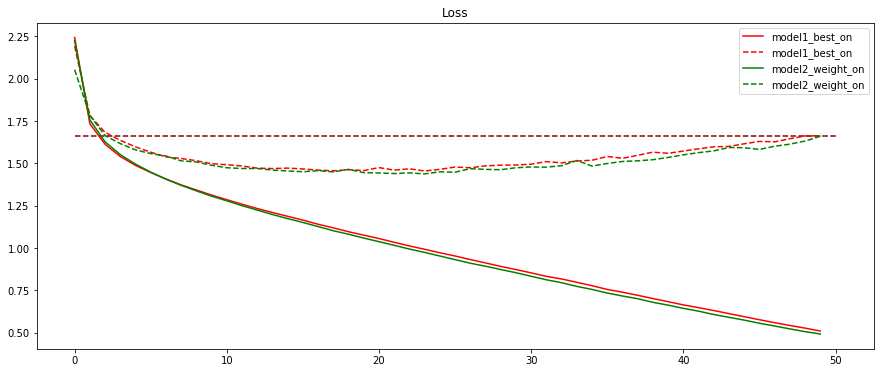

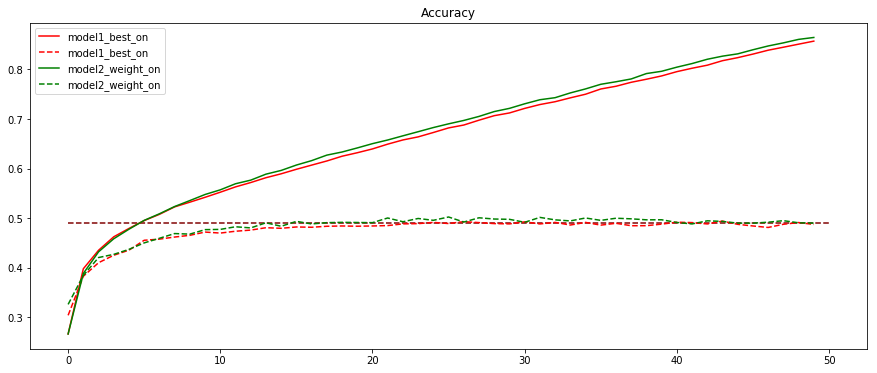

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(15,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
plt.hlines(y=results[cond]['loss_loadback'], xmin=0, xmax=len(train_loss), colors='maroon', linestyles='--')
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(15,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
plt.hlines(y=results[cond]['acc_loadback'], xmin=0, xmax=len(train_loss), colors='maroon', linestyles='--')
plt.title("Accuracy")
plt.legend()
plt.show()